In [ ]:
# Parei a revisão em "Checking out the potential quitting outliers from the IT department "

<h1 style='font-size:40px'> Employee Turnover Predicting Model</h1>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            This project aims to build a binary classifier that correctly predicts if a given employee is going to stay or quit the company.
        </li>
        <li> 
            The dataset used was encountered in a <a href='https://www.coursera.org/projects/employee-turnover-scikit-learn'>Coursera Guided Project</a>. Nonetheless, I've decided to produce my own solution to the case, which is different from the platform instructor's.
        </li>
    </ul>
</div>

<h2 style='font-size:30px'> Loading the Data</h2>

In [1]:
import pandas as pd
import numpy as np

# Since I am looking to create more columns to the DF, I'll modify the maximum number of columns that can be displayed.
pd.set_option('max_columns', None)

# Importing the employee data.
employee_data = pd.read_csv('employee_data.csv')
employee_data.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  quit  promotion_last_5years department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

In [2]:
# Searching for anomalies in the DataFrame. All features do not present any null value and have its proper data type assigned.
employee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   quit                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


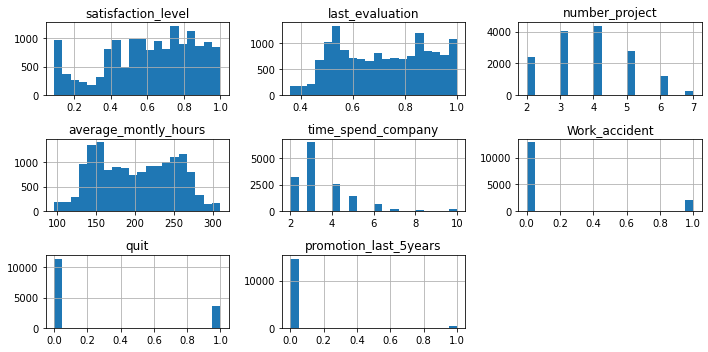

In [3]:
# Plotting a histograms frame looking for outliers.
import matplotlib.pyplot as plt
employee_data.hist(bins=20, figsize=(10,5));
plt.tight_layout()

<div> 
    <ul style='font-size:20px'> 
        <li> 
            The number of people who've spent more than 7 years in the enterprise looks proportionately very small. It could be a potential indicator for disconsidering them in model training. However, it is worth to consider that keeping experienced workers is often a healthy attitude for the corporation since they can guide the younger ones during daily tasks and projects.
        </li>
        <li> 
            Also, it is important to acknowledge that we are dealing with a dataset with an unbalanced quantity of target values. The great amount of 0's will likely make it easier for the models to correctly identify them. On the other hand, the lower number of 1's requires a higher efficiency of the algorithms to apprehend the patterns among the class' instances.
        </li>
    </ul>
</div>

<h2 style='font-size:30px'> Training and Test Sets</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Since salary is one of the main aspects considered whenever someone is deciding to stay or leave their enterprise, I'll attempt to maintain the proportions of such feature. Fortunately, it is already labeled with categories so we don't need to encode any of its values.
        </li>
    </ul>
</div>

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(employee_data, employee_data.salary):
    train = employee_data.loc[train_index]
    test = employee_data.loc[test_index]

<h2 style='font-size:30px'> Exploratory Analysis on the Training Data</h2>

<h3 style='font-size:30px;font-style:italic'> Adding new stats</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Before diving into the data examination, it is interesting to use the data we already have in order to generate new stats that might be prove useful to our models.
        </li>
        <li> 
            The new columns to be added are:
            <ul style='list-style-type:lower-alpha'>
                <li> No of projects per years of work.</li>
                <li> Harmonic mean between the satisfaction levels and last evaluation.</li>
            </ul>
        </li>
    </ul>
</div>

In [6]:
from scipy.stats import hmean
train['number_project_per_time_spend'] = train.number_project / train.time_spend_company

# Using harmonic mean can highlight possible discrepancies between the values. For instance, a given worker might be very unsatisfied (0.2)
# with the company, whereas their boss and team exceedingly enjoy working with them (0.9).

# We'll name this stat as 'reciprocity_degree'
train['reciprocity_degree'] = hmean([train.satisfaction_level, train.last_evaluation])

<h3 style='font-size:30px;font-style:italic'> Densities of staying or quitting occurences according to satisfaction and salary</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            The violin plot below exposes, among every salary category, the densities of quitting and staying occurences for every satisfaction degree measured.
        </li>
        <li> 
            In all cases, employees with contentment levels lower than 50% tend to abandon the company.
        </li>
    </ul>
</div>

<AxesSubplot:xlabel='salary', ylabel='satisfaction_level'>

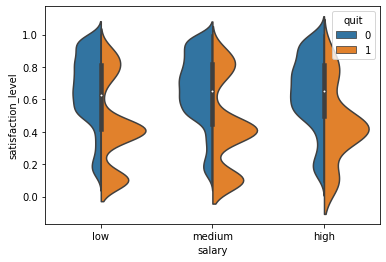

In [7]:
import seaborn as sns
sns.violinplot(data=train, x='salary', y='satisfaction_level', hue='quit',split=True, order=['low', 'medium', 'high'])

<h3 style='font-size:30px;font-style:italic'> Reciprocity scores per Department and Salary</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Now, we are zooming in the analysis about salary and satisfaction scores adding the Department feature.
        </li>
    </ul>
</div>

In [8]:
# Segregating the employees who've quitted and still work in the company.
only_0=train[train.quit==0]
only_1=train[train.quit==1]

In [9]:
# Sorting the pivot tables by 'hr' and 'support' so the index order could be ['low', 'medium', 'high'].
recip0 = pd.pivot_table(data = only_0, index='salary', columns='department', values='reciprocity_degree').sort_values(by='hr')
recip1 = pd.pivot_table(data = only_1, index='salary', columns='department', values='reciprocity_degree').sort_values(by='support')

Text(767.7272727272725, 0.5, '')

<Figure size 720x288 with 0 Axes>

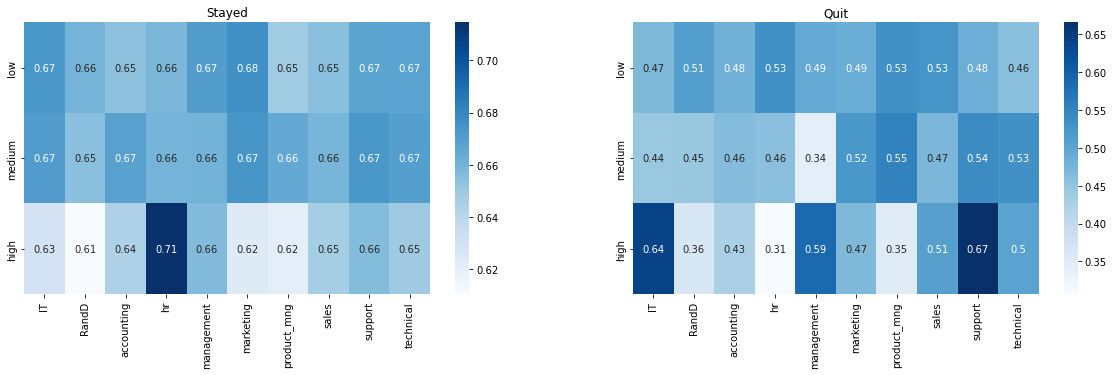

In [10]:
import seaborn as sns
plt.figure(figsize=(10,4))
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.heatmap(recip0, cmap='Blues', annot=True)
plt.xlabel(None)
plt.ylabel(None)
plt.title('Stayed')
plt.subplot(122)
sns.heatmap(recip1, cmap='Blues', annot=True)
plt.title('Quit')
plt.xlabel(None)
plt.ylabel(None)

<div> 
    <ul style='font-size:20px'> 
        <li> 
            There are some pretty interesting insights on both heatmaps. People with high incomes from IT and Support areas who've left their jobs actually had a pretty decent reciprocity levels. They were probably glad with their roles so as their team was with their performance. So what could possibly persuade them to leave?
        </li>
    </ul>
</div>

<h4 style='font-size:30px;font-style:italic;text-decoration:underline'>Checking out the potential quitting outliers from the IT department </h4>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Here, we can see the reason for the high reciprocity levels for the IT area. Two of its leaving workers had some pretty high scores.
        </li>
        <li> 
            Since it is unusual for someone in that condition to decide to leave the company, it is necessary to analyze whether we can find another reason for the departure. If not, we'll consider those employees as noise in the data.
        </li>
    </ul>
</div>

In [11]:
# Checking out the potential quitting outliers from the IT department. There are two people with reciprocity levels higher than 0.8
quit_it = only_1[(only_1['department']=='IT') & (only_1['salary']=='high')]
quit_it

satisfaction_level  last_evaluation  number_project  \
1281                0.75             0.88               5   
1515                0.72             0.99               5   
1359                0.46             0.46               2   
1437                0.40             0.53               2   

      average_montly_hours  time_spend_company  Work_accident  quit  \
1281                   270                   5              0     1   
1515                   257                   5              0     1   
1359                   145                   3              0     1   
1437                   155                   3              0     1   

      promotion_last_5years department salary  number_project_per_time_spend  \
1281                      0         IT   high                       1.000000   
1515                      0         IT   high                       1.000000   
1359                      0         IT   high                       0.666667   
1437                      0         IT   high                       0.666667   

      reciprocity_degree  
1281            0.809816  
1515            0.833684  
1359            0.460000  
1437            0.455914

In [12]:
# Extracting the mean of the features from the quitting workers.
quit_it[quit_it['reciprocity_degree']>0.8].mean()

/tmp/ipykernel_141558/2561073071.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  quit_it[quit_it['reciprocity_degree']>0.8].mean()


satisfaction_level                 0.73500
last_evaluation                    0.93500
number_project                     5.00000
average_montly_hours             263.50000
time_spend_company                 5.00000
Work_accident                      0.00000
quit                               1.00000
promotion_last_5years              0.00000
number_project_per_time_spend      1.00000
reciprocity_degree                 0.82175
dtype: float64

In [13]:
# Now, looking at the staying workers with similar characteristics as those two, is there any aspect that can differentiate
# them?
only_0[(only_0['department']=='IT') & (only_0['salary']=='high') & (only_0['reciprocity_degree']>0.8)].mean()

/tmp/ipykernel_141558/4191362253.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  only_0[(only_0['department']=='IT') & (only_0['salary']=='high') & (only_0['reciprocity_degree']>0.8)].mean()


satisfaction_level                 0.925000
last_evaluation                    0.805000
number_project                     3.625000
average_montly_hours             198.250000
time_spend_company                 3.000000
Work_accident                      0.125000
quit                               0.000000
promotion_last_5years              0.000000
number_project_per_time_spend      1.291667
reciprocity_degree                 0.857455
dtype: float64

<div> 
    <ul style='font-size:20px'> 
        <li> 
            The answer is yes! The deserters have a lower satisfaction score and work for many more hours than their staying counterparts. Therefore, we won't consider them as noise.
        </li>
    </ul>
</div>

<h4 style='font-size:30px;font-style:italic;text-decoration:underline'>Checking out the potential quitting outliers from the Support department </h4>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Doing the same process now regarding the Support area. In this case, there are three employees with a reciprocity level higher than 0.8.
        </li>
    </ul>
</div>

In [14]:
quit_support = only_1[(only_1['department']=='support') & (only_1['salary']=='high')]
quit_support

satisfaction_level  last_evaluation  number_project  \
891                  0.75             0.86               5   
735                  0.83             0.99               5   
12657                0.43             0.55               2   
12735                0.83             0.99               5   
813                  0.15             0.55               6   

       average_montly_hours  time_spend_company  Work_accident  quit  \
891                     237                   5              0     1   
735                     258                   5              0     1   
12657                   130                   3              0     1   
12735                   258                   5              0     1   
813                     139                   4              0     1   

       promotion_last_5years department salary  number_project_per_time_spend  \
891                        0    support   high                       1.000000   
735                        0    support   high                       1.000000   
12657                      0    support   high                       0.666667   
12735                      0    support   high                       1.000000   
813                        0    support   high                       1.500000   

       reciprocity_degree  
891              0.801242  
735              0.902967  
12657            0.482653  
12735            0.902967  
813              0.235714

In [15]:
# Extracting the mean of the features from the quitting workers.
quit_support[quit_support['reciprocity_degree']>0.8].mean()

/tmp/ipykernel_141558/1204098167.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  quit_support[quit_support['reciprocity_degree']>0.8].mean()


satisfaction_level                 0.803333
last_evaluation                    0.946667
number_project                     5.000000
average_montly_hours             251.000000
time_spend_company                 5.000000
Work_accident                      0.000000
quit                               1.000000
promotion_last_5years              0.000000
number_project_per_time_spend      1.000000
reciprocity_degree                 0.869059
dtype: float64

In [16]:
# Doing the same for those who still work for the enterprise.
only_0[(only_0['department']=='support') & (only_0['salary']=='high') & (only_0['reciprocity_degree']>0.8)].mean()

/tmp/ipykernel_141558/2206320805.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  only_0[(only_0['department']=='support') & (only_0['salary']=='high') & (only_0['reciprocity_degree']>0.8)].mean()


satisfaction_level                 0.878800
last_evaluation                    0.874400
number_project                     3.720000
average_montly_hours             200.520000
time_spend_company                 3.000000
Work_accident                      0.160000
quit                               0.000000
promotion_last_5years              0.000000
number_project_per_time_spend      1.405333
reciprocity_degree                 0.870608
dtype: float64

<div> 
    <ul style='font-size:20px'> 
        <li> 
            Here, the satisfaction score doesn't seem to be part of the problem. However, the deserters still work for more hours than the ones who yet are employed in the company.
        </li>
    </ul>
</div>

<h3 style='font-size:30px;font-style:italic'> Workload as a factor for departure</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            The quantity of tasks that are assigned to a given worker is a relevant aspect regarding their satisfaction. Offering fewer projects can make them feel undervalued; at the same time, participating in a high number of activities is prone to become something stressful.
        </li>
    </ul>
</div>

In [18]:
# For each department, what is the average number of projects that the quitting and staying people have been assigned?
# Let's plot another pair of heatmaps to check if there are any differences.
projec_per_0 = pd.pivot_table(data = only_0, index='department', values='number_project_per_time_spend')
projec_per_1 = pd.pivot_table(data = only_1, index='department', values='number_project_per_time_spend')

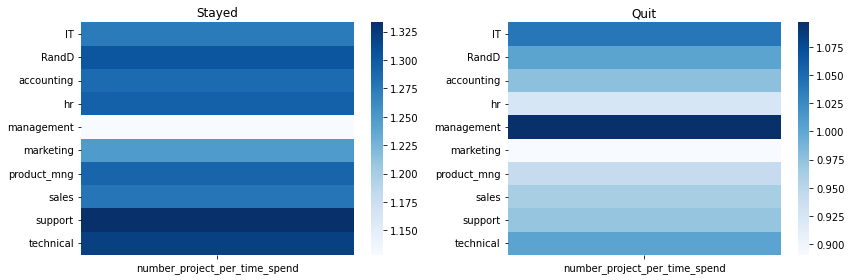

In [19]:
plt.figure(figsize=(12,4))
# Heatmap for those who are still employed.
plt.subplot(121)
sns.heatmap(projec_per_0, cmap='Blues')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Stayed')
# Heatmap for those who have left their jobs.
plt.subplot(122)
sns.heatmap(projec_per_1, cmap='Blues')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Quit')
plt.tight_layout()

<div> 
    <ul style='font-size:20px'> 
        <li> 
            The deserters tend to have a slightly lower average amount of projects during their tenure. This is evident just by looking at the colorbars' scale.
        </li>
    </ul>
</div>

<h2 style='font-size:30px'> Treating the Dataset</h2>
<h3 style='font-size:30px;font-style:italic'> Numerical data</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Fortunately, most of the columns dealing with integers and floats are almost adequate to be applied in a model.
        </li>
        <li>
            Nevertheless, they need to be normalized. Also, it would be interesting to automate the creation of the features engendered in the beginning of the script.
        </li>
    </ul>
</div>

In [20]:
i=0
for column in train.columns:
    print(i, '-->', column)
    i+=1

0 --> satisfaction_level
1 --> last_evaluation
2 --> number_project
3 --> average_montly_hours
4 --> time_spend_company
5 --> Work_accident
6 --> quit
7 --> promotion_last_5years
8 --> department
9 --> salary
10 --> number_project_per_time_spend
11 --> reciprocity_degree


In [21]:
# The class below is a transformer that creates the extra features.
from sklearn.base import BaseEstimator, TransformerMixin

class NewNumFeatures(BaseEstimator, TransformerMixin):
    # Importing scipy.stats' hmean method.
    from scipy.stats import hmean
    def __init__(self, number_project_per_time_spend=True, reciprocity_degree=True):
        
        # This allows the user to choose whether they want to unable the generation of one of the features.
        self.number_project_per_time_spend = number_project_per_time_spend
        self.reciprocity_degree = reciprocity_degree
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Making the new features.
        if self.number_project_per_time_spend:
            X.loc[:,'number_project_per_time_spend'] = X.loc[:,'number_project'] / X.loc[:,'time_spend_company']

        if self.reciprocity_degree:
            X.loc[:,'reciprocity_degree'] = hmean([X.loc[:,'satisfaction_level'], X.loc[:,'last_evaluation']])

        return X.values

In [24]:
# Building the transformation pipeline for the numerical values.
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

num_pipeline = Pipeline([
    ('new_features', NewNumFeatures()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('min_max', MinMaxScaler())    
])

<h3 style='font-size:30px;font-style:italic'> Text data</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Since most of the scikit-learn models cannot handle strings as features, the textual informations from the dataset need to be treated.
        </li>
        <li> 
            The mission thus is trying to find numerical data based on the string informations.
        </li>
    </ul>
</div>

In [25]:
# One way to do such thing is attempting to discover the quitting rate for the categories from each column.

# For instance, let's find out the departure rate among the income levels.
gp = train.groupby(['salary','quit'])['quit'].size()
employees_per_salary = gp.sum(level=1)

quitting_rate_salary = (gp/employees_per_salary).xs(1, level=1)
quitting_rate_salary

/tmp/ipykernel_141558/3537221126.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  employees_per_salary = gp.sum(level=1)


salary
high      0.023085
low       0.601959
medium    0.374956
Name: quit, dtype: float64

In [26]:
# The column labels could be readily changed for the quitting indices with a 'replace'. 
train.salary.replace(quitting_rate_salary.to_dict())

11263    0.374956
1753     0.374956
3981     0.601959
14300    0.601959
12943    0.023085
           ...   
13235    0.374956
7785     0.601959
7882     0.023085
11061    0.374956
5936     0.374956
Name: salary, Length: 11999, dtype: float64

<div> 
    <ul style='font-size:20px'> 
        <li>
            The same process is possible to be carried out with the department column, so it would be a good idea to create a transformer which automatically handles this task.
        </li>
    </ul>
</div>

In [27]:
class MeaningFromText(BaseEstimator, TransformerMixin):
    # Here, the individual can cancel the transformation for one of the given columns.
    def __init__(self, salary=True, department=True):
        self.salary=salary
        self.department=department
        
    def fit(self, X,y=None):
        return self
    
    def transform(self, X):
        global train
        if self.salary:
            quitting_and_staying = train.groupby(['salary','quit'])['quit'].size()
            employees_per_category = quitting_and_staying.sum(level=1)
            quitting_rates = (quitting_and_staying/employees_per_category).xs(1, level=1)
            # Placing the quitting rates as a new column for the DF experiencing the transformation.
            X.loc[:,'quitting_rates_salary'] = X.salary.replace(quitting_rates.to_dict())
            
        if self.department:
            quitting_and_staying = train.groupby(['department','quit'])['quit'].size()
            employees_per_category = quitting_and_staying.sum(level=1)
            quitting_rates = (quitting_and_staying/employees_per_category).xs(1, level=1)
            X.loc[:,'quitting_rates_department'] = X.department.replace(quitting_rates.to_dict())
        # Dropping out the columns with textual data.
        X.drop(['salary', 'department'], axis=1, inplace=True)
        return X.values

In [28]:
# Finally, constructing the pipeline for the text data.
text_pipeline = Pipeline([
            ('transformer', MeaningFromText()),
            ('imputer', SimpleImputer(strategy='most_frequent'))])

<h3 style='font-size:30px;font-style:italic'> Full Transformation Pipeline</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            It is time to fusion both pipelines built into a single one.
        </li>
    </ul>
</div>

In [29]:
# Firstly, dropping out the columns that were created without the use of the transformator.
train.drop(['number_project_per_time_spend', 'reciprocity_degree'], axis=1, inplace=True)

In [31]:
from sklearn.compose import ColumnTransformer
# Segregating the independent from the dependent variables.
X = train[[column for column in train.columns if column != 'quit']]
y = train['quit']
num_cols = [column for column in X.columns if X[column].dtype=='float64' or X[column].dtype=='int64']
text_cols = [column for column in X.columns if X[column].dtype=='object']

full_pipeline = ColumnTransformer([
                ('num', num_pipeline, num_cols),
                ('text', text_pipeline, text_cols)
                ])

# We are ready to try out our first models.
X = full_pipeline.fit_transform(X)

/tmp/ipykernel_141558/1796859430.py:14: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  employees_per_category = quitting_and_staying.sum(level=1)
/tmp/ipykernel_141558/1796859430.py:21: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  employees_per_category = quitting_and_staying.sum(level=1)


<h2 style='font-size:30px'> Initial Validations</h2>
<h3 style='font-size:30px;font-style:italic'> Naïve Bayes</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            I've chosen Naïve Bayes as the first model to be tried because it is a simpler algorithm that can provide us a base value for the error score.
        </li>
    </ul>
</div>

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
bayes_f1 = cross_val_score(bayes, X, y, cv=5, scoring='roc_auc', verbose=2)

# The best model experimented had a Area Under the Curve of roughly 87%.
bayes_f1.max()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


0.8721844348211963

<h3 style='font-size:30px;font-style:italic'> Logistic Regression</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Logistic Regression is kind of a cliché for binary classification tasks. Let's find out how well it goes with the data.
        </li>
    </ul>
</div>

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
param_grid = {'C':[1000, 2500, 5000, 10000],
               'solver':['lbfgs', 'liblinear']}

log_reg_gscv = GridSearchCV(log_reg, param_grid=param_grid, scoring='roc_auc', cv=5,
                           verbose=2)
log_reg_gscv.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...............................C=1000, solver=lbfgs; total time=   0.2s
[CV] END ...............................C=1000, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=1000, solver=lbfgs; total time=   0.2s
[CV] END ...............................C=1000, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=1000, solver=lbfgs; total time=   0.2s
[CV] END ...........................C=1000, solver=liblinear; total time=   0.1s
[CV] END ...........................C=1000, solver=liblinear; total time=   0.1s
[CV] END ...........................C=1000, solver=liblinear; total time=   0.1s
[CV] END ...........................C=1000, solver=liblinear; total time=   0.1s
[CV] END ...........................C=1000, solver=liblinear; total time=   0.1s
[CV] END ...............................C=2500, solver=lbfgs; total time=   0.2s
[CV] END ...............................C=2500, s

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1000, 2500, 5000, 10000],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc', verbose=2)

In [34]:
# Looks like we've managed to obtain a slightly better score!
print(log_reg_gscv.best_params_)
log_reg_gscv.best_score_

{'C': 10000, 'solver': 'lbfgs'}


0.9136747281371956

<h3 style='font-size:30px;font-style:italic'> Random Forests</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Random Forests can be a useful algorithm for validation improving. We can perform this model and use its 'feature_importances_' attribute in order to filter out the most irrelevant features of the dataset.
        </li>
    </ul>
</div>

In [35]:
from sklearn.ensemble import RandomForestClassifier
random_for = RandomForestClassifier()
param_grid = {'max_depth':[3,4,5],
             'n_estimators':[25, 50, 75, 100],
             'max_features':[2,3,4]}
random_for_gscv = GridSearchCV(random_for, param_grid=param_grid, scoring='roc_auc', cv=5,
                           verbose=2)
random_for_gscv.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .......max_depth=3, max_features=2, n_estimators=25; total time=   0.1s
[CV] END .......max_depth=3, max_features=2, n_estimators=25; total time=   0.1s
[CV] END .......max_depth=3, max_features=2, n_estimators=25; total time=   0.1s
[CV] END .......max_depth=3, max_features=2, n_estimators=25; total time=   0.1s
[CV] END .......max_depth=3, max_features=2, n_estimators=25; total time=   0.1s
[CV] END .......max_depth=3, max_features=2, n_estimators=50; total time=   0.2s
[CV] END .......max_depth=3, max_features=2, n_estimators=50; total time=   0.2s
[CV] END .......max_depth=3, max_features=2, n_estimators=50; total time=   0.2s
[CV] END .......max_depth=3, max_features=2, n_estimators=50; total time=   0.2s
[CV] END .......max_depth=3, max_features=2, n_estimators=50; total time=   0.2s
[CV] END .......max_depth=3, max_features=2, n_estimators=75; total time=   0.3s
[CV] END .......max_depth=3, max_features=2, n_

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 4, 5], 'max_features': [2, 3, 4],
                         'n_estimators': [25, 50, 75, 100]},
             scoring='roc_auc', verbose=2)

In [36]:
# The algorithm's roc_auc is great. But notice that the dataset has a handful of features that have no use
# for the predictions. Let's verify whether removing them from the data can still improve the score.
print(random_for_gscv.best_score_)
print(random_for_gscv.best_estimator_.feature_importances_.round(2))

0.9819344730493593
[0.27 0.05 0.12 0.07 0.15 0.   0.   0.09 0.24 0.   0.  ]


<h2 style='font-size:30px'> Discarding non-important features</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Providing irrelevant data can compromise the models' performance. So it would be convenient for us to discard them with the use of a transformer.
        </li>
    </ul>
</div>

In [37]:
# 'KeepReleveantFeatures' will maintain the k most relevant features in the dataset.
class KeepReleveantFeatures(BaseEstimator, TransformerMixin):
    # The user needs to declare the feature importances array along the value of k.
    def __init__(self, features_importances, k):
        self.features_importances=features_importances
        self.k = k
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Listing the features to be deleted.
        feature_importances_delete = pd.Series(self.features_importances).sort_values(ascending=False).iloc[self.k:].index
        # Deleting them and returning the transformed array.
        X = np.delete(X, feature_importances_delete, axis=1)
        return X

In [38]:
# Adding the transformer to the data cleaning pipeline.
# In this case, we'll keep the 5 most important features.
X = train[[column for column in train.columns if column != 'quit']]
feature_importances = random_for_gscv.best_estimator_.feature_importances_
k = 5
full_pipeline_imprt_ftr = Pipeline([
            ('full_pipe', full_pipeline),
            ('k_important_features', KeepReleveantFeatures(feature_importances, k))
])
X = full_pipeline_imprt_ftr.fit_transform(X)

/tmp/ipykernel_141558/1796859430.py:14: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  employees_per_category = quitting_and_staying.sum(level=1)
/tmp/ipykernel_141558/1796859430.py:21: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  employees_per_category = quitting_and_staying.sum(level=1)


<h2 style='font-size:30px'> Second phase of Validations</h2>
<h3 style='font-size:30px;font-style:italic'> Random Forests (II)</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Let's see if any impact occurs when we delete the non-important features from the array.
        </li>
    </ul>
</div>

In [39]:
random_for2 = RandomForestClassifier()
param_grid = {'max_depth':[5,6],
             'n_estimators':[25, 50, 75, 100],
             'max_features':[4,5]}
random_for_gscv2 = GridSearchCV(random_for2, param_grid=param_grid, scoring='roc_auc', cv=5,
                           verbose=2)
random_for_gscv2.fit(X, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......max_depth=5, max_features=4, n_estimators=25; total time=   0.2s
[CV] END .......max_depth=5, max_features=4, n_estimators=25; total time=   0.2s
[CV] END .......max_depth=5, max_features=4, n_estimators=25; total time=   0.2s
[CV] END .......max_depth=5, max_features=4, n_estimators=25; total time=   0.2s
[CV] END .......max_depth=5, max_features=4, n_estimators=25; total time=   0.2s
[CV] END .......max_depth=5, max_features=4, n_estimators=50; total time=   0.3s
[CV] END .......max_depth=5, max_features=4, n_estimators=50; total time=   0.3s
[CV] END .......max_depth=5, max_features=4, n_estimators=50; total time=   0.4s
[CV] END .......max_depth=5, max_features=4, n_estimators=50; total time=   0.3s
[CV] END .......max_depth=5, max_features=4, n_estimators=50; total time=   0.3s
[CV] END .......max_depth=5, max_features=4, n_estimators=75; total time=   0.5s
[CV] END .......max_depth=5, max_features=4, n_e

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 6], 'max_features': [4, 5],
                         'n_estimators': [25, 50, 75, 100]},
             scoring='roc_auc', verbose=2)

In [47]:
# The improvement was not the highest. Nonetheless, we can still try out the new array with other models.
print(random_for_gscv2.best_estimator_)
random_for_gscv2.best_score_

RandomForestClassifier(max_depth=6, max_features=4)


0.9846537596681543

<h3 style='font-size:30px;font-style:italic'> Logistic Regression (II)</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Checking if the transformation can upgrade the Logistic Regression's ROC-AUC score.
        </li>
    </ul>
</div>

In [41]:
log_reg2 = LogisticRegression()
param_grid = {'C':[10e4, 10e5, 10e6, 10e7],
               'solver':['lbfgs', 'liblinear']}

log_reg_gscv2 = GridSearchCV(log_reg2, param_grid=param_grid, scoring='roc_auc', cv=5,
                           verbose=2)
log_reg_gscv2.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...........................C=100000.0, solver=lbfgs; total time=   0.1s
[CV] END ...........................C=100000.0, solver=lbfgs; total time=   0.1s
[CV] END ...........................C=100000.0, solver=lbfgs; total time=   0.1s
[CV] END ...........................C=100000.0, solver=lbfgs; total time=   0.1s
[CV] END ...........................C=100000.0, solver=lbfgs; total time=   0.1s
[CV] END .......................C=100000.0, solver=liblinear; total time=   0.1s
[CV] END .......................C=100000.0, solver=liblinear; total time=   0.1s
[CV] END .......................C=100000.0, solver=liblinear; total time=   0.0s
[CV] END .......................C=100000.0, solver=liblinear; total time=   0.0s
[CV] END .......................C=100000.0, solver=liblinear; total time=   0.0s
[CV] END ..........................C=1000000.0, solver=lbfgs; total time=   0.1s
[CV] END ..........................C=1000000.0, s

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [100000.0, 1000000.0, 10000000.0, 100000000.0],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc', verbose=2)

In [46]:
# That was not the case.
log_reg_gscv2.best_params_, log_reg_gscv2.best_score_

({'C': 10000000.0, 'solver': 'lbfgs'}, 0.9010711873316396)

<h3 style='font-size:30px;font-style:italic'> Support Vector Machines</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            SVM's are designed to handle binary classification tasks. They could not be forgotten for such project. 
        </li>
    </ul>
</div>

In [43]:
from sklearn.svm import SVC
svc = SVC()
param_grid = {'kernel':['poly', 'rbf'],
             'C':[1e-5, 1e-2, 1e2, 1e3],
             'degree':[1,3]}
svc_gscv = GridSearchCV(svc, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2)
svc_gscv.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................C=1e-05, degree=1, kernel=poly; total time=   2.1s
[CV] END .....................C=1e-05, degree=1, kernel=poly; total time=   1.7s
[CV] END .....................C=1e-05, degree=1, kernel=poly; total time=   1.7s
[CV] END .....................C=1e-05, degree=1, kernel=poly; total time=   2.0s
[CV] END .....................C=1e-05, degree=1, kernel=poly; total time=   2.0s
[CV] END ......................C=1e-05, degree=1, kernel=rbf; total time=   2.6s
[CV] END ......................C=1e-05, degree=1, kernel=rbf; total time=   2.7s
[CV] END ......................C=1e-05, degree=1, kernel=rbf; total time=   2.6s
[CV] END ......................C=1e-05, degree=1, kernel=rbf; total time=   2.7s
[CV] END ......................C=1e-05, degree=1, kernel=rbf; total time=   2.7s
[CV] END .....................C=1e-05, degree=3, kernel=poly; total time=   2.0s
[CV] END .....................C=1e-05, degree=3,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1e-05, 0.01, 100.0, 1000.0], 'degree': [1, 3],
                         'kernel': ['poly', 'rbf']},
             scoring='roc_auc', verbose=2)

In [45]:
# Looks like we've found another contender fot being the deployement model!
svc_gscv.best_params_, svc_gscv.best_score_

({'C': 1000.0, 'degree': 1, 'kernel': 'rbf'}, 0.9744084525068066)

<h3 style='font-size:30px;font-style:italic'> Neural Networks</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Neural Networks are capable of finding relationships among features that are not readily visible to humans. It is worth trying them even though they demand a high computational cost. 
        </li>
    </ul>
</div>

In [54]:
from sklearn.neural_network import MLPClassifier
neural = MLPClassifier(solver='lbfgs', max_iter=1000)
param_grid = {'hidden_layer_sizes':[[25,50],[50,50]],
             'activation':['relu', 'tanh']}
neural_gscv = GridSearchCV(neural, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2)
neural_gscv.fit(X,y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=relu, hidden_layer_sizes=[25, 50]; total time=  31.3s


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=relu, hidden_layer_sizes=[25, 50]; total time=  31.9s


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=relu, hidden_layer_sizes=[25, 50]; total time=  33.5s


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=relu, hidden_layer_sizes=[25, 50]; total time=  32.8s


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=relu, hidden_layer_sizes=[25, 50]; total time=  34.7s


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=relu, hidden_layer_sizes=[50, 50]; total time=  41.4s


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=relu, hidden_layer_sizes=[50, 50]; total time=  41.4s


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=relu, hidden_layer_sizes=[50, 50]; total time=  46.1s


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=relu, hidden_layer_sizes=[50, 50]; total time=  41.4s


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=relu, hidden_layer_sizes=[50, 50]; total time=  41.3s


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=tanh, hidden_layer_sizes=[25, 50]; total time= 1.3min


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=tanh, hidden_layer_sizes=[25, 50]; total time= 1.3min


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=tanh, hidden_layer_sizes=[25, 50]; total time= 1.2min


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=tanh, hidden_layer_sizes=[25, 50]; total time= 1.2min


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=tanh, hidden_layer_sizes=[25, 50]; total time= 1.3min


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=tanh, hidden_layer_sizes=[50, 50]; total time= 1.7min


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=tanh, hidden_layer_sizes=[50, 50]; total time= 1.7min


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=tanh, hidden_layer_sizes=[50, 50]; total time= 1.7min


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=tanh, hidden_layer_sizes=[50, 50]; total time= 1.6min


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END .......activation=tanh, hidden_layer_sizes=[50, 50]; total time= 1.7min


/home/veiga/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000, solver='lbfgs'),
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [[25, 50], [50, 50]]},
             scoring='roc_auc', verbose=2)

In [101]:
# We now have 3 highly promissing models to make the final evaluation.
neural_gscv.best_params_, neural_gscv.best_score_

({'activation': 'tanh', 'hidden_layer_sizes': [50, 50]}, 0.984455562453657)

<h2 style='font-size:30px'> Choosing the Deployment Model</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            It is time to evaluate the performance of the algorithms against the test set. By first, it is necessary to apply the transformations required.
        </li>
    </ul>
</div>

In [97]:
X_test = test[[column for column in test.columns if column !='quit']]
y_test = test['quit']
X_test = full_pipeline_imprt_ftr.transform(X_test)

/tmp/ipykernel_141558/1796859430.py:14: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  employees_per_category = quitting_and_staying.sum(level=1)
/tmp/ipykernel_141558/1796859430.py:21: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  employees_per_category = quitting_and_staying.sum(level=1)


<h3 style='font-size:30px;font-style:italic'> Random Forests</h3>

In [79]:
from sklearn.metrics import roc_auc_score
random_for_pred = random_for_gscv2.best_estimator_.predict(X_test)
roc_auc_score(y_test, random_for_pred)

0.9533226604855819

<h3 style='font-size:30px;font-style:italic'> Support Vector Machines</h3>

In [80]:
svc_pred = svc_gscv.best_estimator_.predict(X_test)
roc_auc_score(y_test, svc_pred)

0.9531974345878842

<h3 style='font-size:30px;font-style:italic'> Neural Networks</h3>

In [98]:
neural_pred = neural_gscv.best_estimator_.predict(X_test)
roc_auc_score(y_test, neural_pred)

0.9623266480710301

<h2 style='font-size:30px'> Final Judgement</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Though all three algorithms achieved an excellent ROC AUC score, the neural network was approximately 1% better than the Support Vector Machine and Random Forest and therefore it will be the deployment model.
        </li>
    </ul>
</div>

In [107]:
# Leaving the Neural Network ready for use.
deployment_model = Pipeline([
            ('data_preparation', full_pipeline_imprt_ftr),
            ('neural_network', neural_gscv.best_estimator_)])